# LIPS : Learning Industrial physical simulationbenchmark suite (PowerGrid)

The benchmarking platform (as it can be observed in the Figure below) is composed of three main modules: Data, Benchmarking and Evaluation. As the names suggest, each module is specialized with its own set of functions for a specific task. The Data module is the one that helps to generate different dataset and distributions providing a high flexibility using a set of parameters. Once the datasets are generated, the benchmarking platform will take as entry the generated dataset and perform a required benchmark on it. Each benchmark could be precised via the inputs and outputs required for modeling and prediction. Finally, in order to evaluate the performance of each benchmark, the Evaluation module provides a set of functions to inspect the models from different point of views (physics compliances, machine learning metrics, adaptability and readiness.  

The figure below presents the scheme of benchmarking platform which is composed of three distinct parts : 
* DataSet: Generate some dataset for training and evaluation 
* Benchmark: coordinates between different parts and allows train and evaluate an agumented simulator 
* Evaluation: once the benchmark done, it allow to evaluate the performance with respect to various point of views

![title](img/Benchmarking_scheme_v2.png)

# Benchmark1: Risk assessment through contingency screening
Table of contents:
- [1. Creating Benchmark](#create-benchmark)
- [2. Torch Augmented Simulator](#simulator-torch)
    - [step 1](#step1)
    - [step 2](#step2)
    - [step 3](#step3)
- [3. Tensorflow Augmented Simulator](#simulator-torch)
    - [3.1 Fully connected neural network](#tf-fc)
    - [3.2 LeapNet neural network](#tf-leapnet)
- [Benchmark2](#benchmark2)
- [Benchmark3](#benchmark3)

## 1. Creating a Benchmark and loading corresponding data <a class="anchor" id="create-benchmark"></a>

In this notebook, we analyze the first benchmark's scenario. 

### Benchmark 1 : Risk assessment through contingency screening
The first power grid benchmark tackles the step of risk assessment in power grids. The problem is to anticipate potential threats on the power grid (several hours ahead) and warn the operators accordingly. It simulates incidents (aka contingencies) involving various elements of the grid (such as the disconnection of a line/production unit), one by one. For each contingency, a risk (weakness of the grid) is detected when overloads are detected by the simulation engine on some lines. On a real grid, this scenario means running several dozens of thousands of simulations, thereby, computation time is critical, especially since this risk assessment is refreshed every 15 minutes. In this benchmark, the main physical variable we are interested in is the value of electric current in the lines (in amperes), because an overload is detected if this value exceeds a line-dependent threshold.

In [1]:
import pathlib
from lips import get_root_path
from pprint import pprint
from matplotlib import pyplot as plt
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.utils import get_path

Some paths are required to refer to generated datasets, config files, logs and models. 

In [2]:
# indicate required paths
LIPS_PATH = get_root_path(pathlib_format=True).parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_MODEL_PATH = LIPS_PATH / "trained_models" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

## Select a device for execution 

### GPU

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)

### CPU

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

See the list of selected devices

In [ ]:
tf.config.experimental.get_visible_devices()

> ### step 1 <a class="anchor" id="step1"></a>

We create a Power Grid Benchmark by instantiating the corresponding class `PowerGridBenchmark` and by indicating the `benchmark_name` argument.

**NB.** It should be noted that the `Benchmark_name` is related to a section name of a configuration file which is located at the path indicated by the `config_path`. A configuration file (`conf.ini`) is already exists under the config module which defines all the parameters required for three benchmarks studied in power grid use case. 

If the data is already generated for this benchmark, the parametes `load_data_set` can be set to _True_, which allows to load the datasets for the corresponding benchmark using its name indicated by `benchmark_name`.

In [3]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

Once the benchmark is instantiated, we can verify the corresponding configurations.

In [4]:
pprint(benchmark1.config.get_options_dict())

{'attr_tau': ('line_status', 'topo_vect'),
 'attr_x': ('prod_p', 'prod_v', 'load_p', 'load_q'),
 'attr_y': ('a_or', 'a_ex'),
 'benchmark_seeds': {'test_actor_seed': 7,
                     'test_env_seed': 3,
                     'test_ood_topo_actor_seed': 8,
                     'test_ood_topo_env_seed': 4,
                     'train_actor_seed': 5,
                     'train_env_seed': 1,
                     'val_actor_seed': 6,
                     'val_env_seed': 2},
 'chronics': {'test': '.*9[5-9][0-4].*',
              'test_ood': '.*9[5-9][5-9].*',
              'train': '^((?!(.*9[0-9][0-9].*)).)*$',
              'val': '.*9[0-4][0-9].*'},
 'dataset_create_params': {'reference_args': {'max_disc': 0,
                                              'prob_depth': (0.7, 0.3),
                                              'prob_do_nothing': 0.2,
                                              'prob_type': (1.0, 0.0),
                                              'topo_actions': [{'

define some tests as below

In [5]:
import numpy as np
sum(np.sum(~benchmark1._test_ood_topo_dataset.data["line_status"], axis=1) > 2)

0

It can be seen that for this benchmark, the considered input variables include injections to the power grid (`attr_x`) and also the topology related variables (`attr_tau`), which can be exploited differently by each augmented simulator. The outputs (`attr_y`) include only electricity currents (A).

We observe also some environment related parameters (`env_name`and `env_params`).

One can also indicate the evaluation criteria that should be calculated to evaluate the performance of a **trained** augmented simulator. 

For example, for this benchmark, we would like to evaluate some machine learning (`ML`) criteria such as _MSE_, _MAE_ and _MAPE90_ and some physics compliances (`Physics`) such as current positivity (_CURRENT_POS_), as we are in the configuration of a simple benchmark that we would like only predict the electrical currents. 

# 2. Augmentd Simulator using Pytorch <a class="anchor" id="simulator-torch"></a>

> ### step 2 <a class="anchor" id="step2"></a>

We start by training an augmented simualtor on the _Benchmark1_ dataset. 

**NB.** for the moment to be able to use Torch base models, we encourage the users to install _pytorch_ using the instructions provided [here](https://pytorch.org/get-started/locally/).

## Instantiate the torch model

In order to be able to use a _torch_ based model, two following elements are required and a scaler is optional if not recommended (It is highly recommended to use a scaler for a better convergence):
- `TorchSimulator`: This class is a sort of controller which takes as the argument a torch based model and allows to `train`, `evaluate`, `load`, `save`, and some other interesting stuffs (visualisation, etc.).

- Model (sub-class of `torch.nn.Module`) : The torch core model which defines the model architecture and how the different elements interact with each other through the `forward` function which applies the forward pass of neural nets. Some model specific parameters could also be implemented in this class, such as data preparation, as it can be unique to each model, and some meta-data that should be saved or restored.

__NB.__ In LIPS platform, an example of such Model is `TorchFullyConnected` which has been provided in _torch_models_ package under the augmented simulators. 

In [6]:
from lips.augmented_simulators.torch_models.fully_connected import TorchFullyConnected
from lips.augmented_simulators.torch_simulator import TorchSimulator
from lips.dataset.scaler import StandardScaler

In [7]:
torch_sim = TorchSimulator(name="torch_fc",
                           model=TorchFullyConnected,
                           scaler=StandardScaler,
                           log_path=LOG_PATH,
                           device="cuda:0", # use "cpu" if you don't have a GPU available on your machine
                           seed=42,
                           bench_config_path=BENCH_CONFIG_PATH,
                           bench_config_name="Benchmark1",
                           sim_config_path=SIM_CONFIG_PATH / "torch_fc.ini",
                           sim_config_name="DEFAULT", # use the default set of hyper parameters
                           architecture_type="Classical"
                          )

**It is magic, but how the "hyper-parameters" for this augmented simulator could be defined ?**

> Good remark! In LIPS platform with each model, a configuration file is associated which maintain the exclusive set of its hyper-parameters. These configuration file is available at `augmented_simulators/configurations` directory. They could be seen (as you can see below), and one also could modify them on-the-fly by indicating some supplementary arguments (`**kwargs`) to the `TorchSimulator` class.

The parameters used for training and evaluation of this augmented simulator.

In [8]:
pprint(torch_sim.params)

{'activation': 'relu',
 'architecture_type': 'Classical',
 'bench_config_name': 'Benchmark1',
 'bench_config_path': PosixPath('/home/milad/PythonScripts/repos/github/LIPS/configurations/powergrid/benchmarks/l2rpn_case14_sandbox.ini'),
 'ckpt_freq': 50,
 'device': 'cuda:0',
 'dropout': 0.0,
 'epochs': 10,
 'eval_batch_size': 128,
 'input_dropout': 0.0,
 'layer': 'linear',
 'layers': (300, 300, 300, 300),
 'loss': {'name': 'MSELoss',
          'params': {'reduce': None,
                     'reduction': 'mean',
                     'size_average': None}},
 'metrics': ('MAELoss',),
 'name': 'torch_fc',
 'optimizer': {'name': 'adam', 'params': {'lr': 0.0003}},
 'save_freq': False,
 'shuffle': False,
 'sim_config_name': 'DEFAULT',
 'train_batch_size': 128}


## Train it 
We can easily train the augmneted simualtor using the `train` function of our controller (`TorchSimulator`) and by indicating the right set of arguments which are:

- `train_dataset` (mendatory): a dataset, on instances of which the augmented simulator is trained

- `val_dataset` (optional): a dataset, on instances of which the augmented simulator is validated (to study the convergence and overfitting)

- `save_path` (optional): whether to save the model, but don't worry, you can save the model once it is trained using `save` function of the controller. 

- `kwargs` (optional): some supplementary arguments which allows to change the default configurations on-the-fly. For example; we have increased the epoch size here (`epochs=100`) 

In [ ]:
torch_sim.train(benchmark1.train_dataset, benchmark1.val_dataset, save_path=None, epochs=100, train_batch_size=128)

#### Verify the model architecture
We can also print the model structure using a `summary` function of the controller. It can be seen that there are four hidden layers between inputs and outputs of our fully connected neural network without any dropout as the `dropout` parameters are set to $0$.

In [10]:
torch_sim.summary()

TorchFullyConnected(
  (input_layer): Linear(in_features=111, out_features=300, bias=True)
  (input_dropout): Dropout(p=0.0, inplace=False)
  (fc_layers): ModuleList(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.0, inplace=False)
    (1): Dropout(p=0.0, inplace=False)
    (2): Dropout(p=0.0, inplace=False)
  )
  (output_layer): Linear(in_features=300, out_features=40, bias=True)
)


The number of parameters can also be verified using `count_parameters` function of the controller `TorchSimulator`. It can be used to have an image of the complexity of the model. 

In [11]:
print("Number of parameters of the model: ", torch_sim.count_parameters())

Number of parameters of the model:  316540


#### Visualize the performance 
Futhermore, we can also visualize the convergence curves computed during training of the model using `visualize_convergence` function of the controller. 

- The first plot shows the loss function (here we have used mean squared error or `MSE`) used for the learning of the model, on the basis of which the back-propagation is performed. 
- The right hand side shows the metrics that are computed alongside the loss function for supplementary information concerning the model's behavior. Here, we have opted for mean absolute error (`MAE`). 

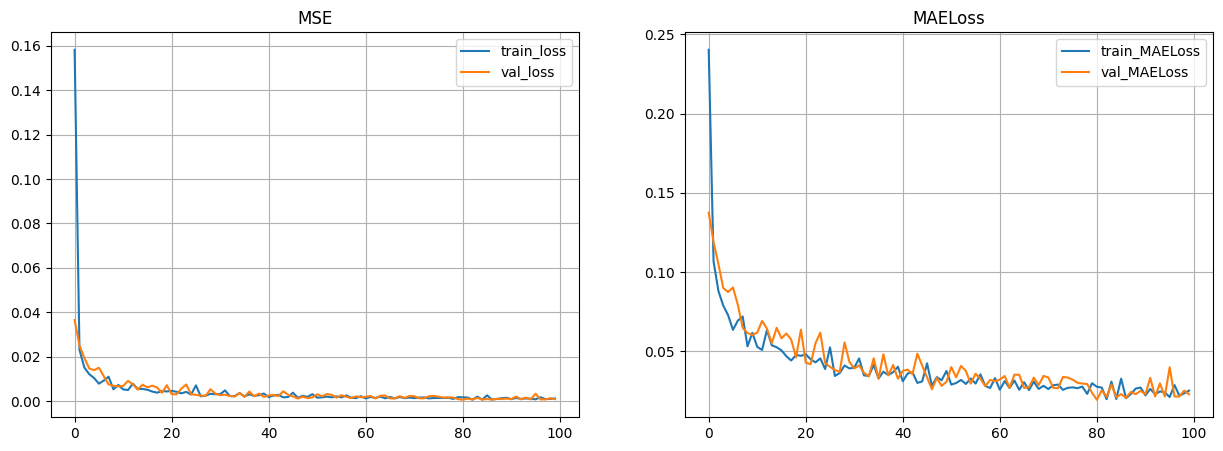

In [12]:
torch_sim.visualize_convergence()

## Evaluate

> ### step 3 <a class="anchor" id="step3"></a>

Once the benchmark is instantiated and an augmented simulator is learned, the time is come to evaluate the performances with a set of criteria gathere from various cateogories which are:
- Machine Learning point of view (ML)
- Physics Compliances (Physics)
- Industrial readiness (IndRed)
- Out-Of-Distribution generalization (OOD)

In order to compute these criteria on the results (predictions) of an augmented simulator, the benchmark module provides an `evaluate_simulator` function which takes following arguments:
- `augmented_simulator`: a **trained** augmented simulator

- `eval_batch_size`: the batch size used for evaluation. From industry point-of-view the whole dataset is not available and could be observed over time. For this reason it is more reasonable to evaluate the data by batches and measure the _inference time_ from industrial point of view.

- `dataset`: the labels of datasets that should be considered for evaluation. It can be `all` if the evaluation should be performed on `val`, `test`, `test_ood_topo` datasets, corresponding to validation, test and out-of-distribution test datasets.

- `shuffle`: should be set to `False` for the moment. The shuffling at the evaluation time does not change anything.  

In [14]:
# TODO: log the losses
EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark1)
torch_sim_metrics = benchmark1.evaluate_simulator(augmented_simulator=torch_sim,
                                                  eval_batch_size=128,
                                                  dataset="all",
                                                  shuffle=False,
                                                  save_path=EVAL_SAVE_PATH,
                                                  save_predictions=True
                                                 )

Once the evaluation has been finished, we can report the evaluation results. The evaluation results are stored in a dictionary and all the steps are logged in a log file located at `LOG_PATH`. 

Every dictionary, contains various level keys:

- The _first level_ corresponds to the datasets labels ("test", "val", "test_ood_topo")

- The _second level_ corresponds to metric categories ("ML", "Physics", "IndRed", "OOD")

- The _third level_ may exist only for some criteria and corresponds to the variable name.

#### Machine Learning 

Here we have reported the Machine Learning (`ML`) metrics for `test` dataset. As it can be seen all the criteria opted in benchmark configuration file are computed for prediction results which are: 

- Average Mean Squared Error (`MSE_avg`)

- Averaged Mean Absolute Error (`MAE_avg`)

- Averaged Mean Absolute Percentage Error computed on 10% of highest current values (`mape_90_avg`)

In [15]:
torch_sim_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 35.50519943237305, 'a_ex': 71.5938491821289},
 'MAE_avg': {'a_or': 3.258171796798706, 'a_ex': 4.677194118499756},
 'mape_90_avg': {'a_or': 0.007850658210688444, 'a_ex': 0.00789267250148531}}

The same set of criteria are also computed on a *out-of-distribution* dataset `test_ood_topo` where the data distribution is not the same during the training and the evaluation phases. There could be more than one disconnected lines observed during the evaluation phase, whereas there is maximum one disconnected line that can be observed during the training.

In [16]:
torch_sim_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 14354.150390625, 'a_ex': 26984.93359375},
 'MAE_avg': {'a_or': 54.52409744262695, 'a_ex': 76.21675872802734},
 'mape_90_avg': {'a_or': 0.20007321642831366, 'a_ex': 0.2000615688793023}}

#### Physics
Here we have reported the Physics Compliances (`Physics`) metrics for `test` dataset. As it can be seen, only the current positivity is computed for this simple first benchmark as it predicts only the electrical currents (currents at the origin `a_or` and at the extremity side `a_ex` of power lines). 

**NB.** It should be noted that more complicated physical laws are relied on more flow variables (active and reactive powers, voltage, voltage angles).

In [17]:
torch_sim_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]

0.0264

In [18]:
torch_sim_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]

0.006205

It can be observed that the fully connected architecture violates the current positivity with a rate of $2\%$.

#### Industrial Readiness

Herein, we can also analyze the time required for the inference phase of the augmented simulator as the objective is to reduce the physical solvers time complexity using an augmented simualtor by maintaining a good prediction precision in terms of various evaluation criteria.

In [19]:
torch_sim_metrics["test"]["IndRed"]

0.025463342666625977

### Save
In order to gain time in future, the trained models could be saved and loaded easily using the `save` and `load` functions offered by the `TorchSimulator`, which save a set of elements required for the model to work independently. More precisely, when you call save, the following informations are saved:

- The learned model weights

- The model configurations (hyper parameters)

- The model meta data infered after training (input and output shapes)

- The losses computed during the training of the augmented simulator

- The scaler parameters (means and standard deviations if `StandardScaler` is used)

In [20]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark1)
torch_sim.save(SAVE_PATH)

### Load
Load it from stored information concerning the model and its hyper-parameters.

To be able to load the dataset the `TorchSimulator` should be instantiated. 

In [21]:
from lips.augmented_simulators.torch_models.fully_connected import TorchFullyConnected
from lips.augmented_simulators.torch_simulator import TorchSimulator
from lips.dataset.scaler import StandardScaler

torch_sim = TorchSimulator(name="torch_fc",
                           model=TorchFullyConnected,
                           scaler=StandardScaler,
                           log_path=LOG_PATH,
                           seed=42,
                           bench_config_path=BENCH_CONFIG_PATH,
                           bench_config_name="Benchmark1",
                           sim_config_path=SIM_CONFIG_PATH / "torch_fc.ini",
                           sim_config_name="DEFAULT" # use the default set of hyper parameters
                          )

Now we can restore the model by calling only the restore which will call some internal functions to load all the metadata and model related informations as weights.

In [22]:
LOAD_PATH = get_path(BASELINES_PATH, benchmark1)
torch_sim.restore(path=LOAD_PATH)

# 3. Augmented Simulator using Tensorflow <a class="anchor" id="tf-simulator"></a>

Here we present the tensorflow based augmented simulators for learning a physical domain. Two different architectures are included for the moment in LIPS framework, which are : 
- Fully Connected Neural Network
- LeapNet Neural network

The tensorflow side implementations are a little bit different from torch based implementations. In order to generalize on more architectures, we allow that each model (architecture) be a subclass of `TensorflowSimulator` base class. The main functions to `train`, `evaluate`, `load`, `save` models are implemented in base class and could be used directly by sub-classes without any overloading. Some specific tasks as data preparation and post processing of predictions could be done using the child classes.

## 3.1 Fully Connected Neural Network <a class="anchor" id="tf-fc"></a>

In [7]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

In [8]:
tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark1",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

### Train it

In [ ]:
tf_fc.train(train_dataset=benchmark1.train_dataset,
            val_dataset=benchmark1.val_dataset,
            epochs=100
           )

In [26]:
print("Number of parameters :", tf_fc.count_parameters())

Number of parameters : 316540


In [ ]:
tf_fc.summary()

Save a visulaization of the architecture on disk

In [28]:
tf_fc.plot_model(path=".")

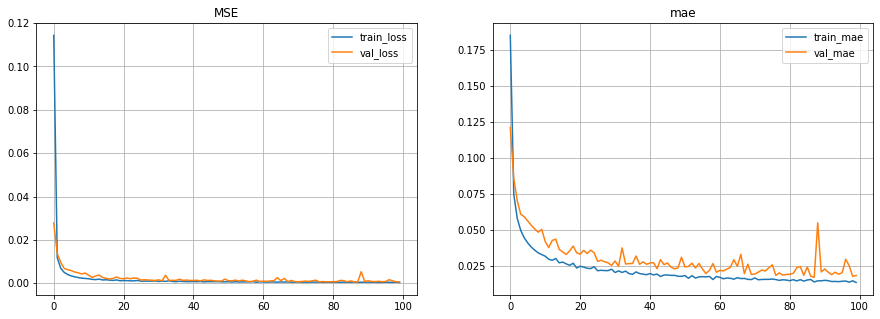

In [28]:
tf_fc.visualize_convergence()

### Evaluation 

In [ ]:
# TODO: log the losses
EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark1)
tf_fc_metrics = benchmark1.evaluate_simulator(augmented_simulator=tf_fc,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_path=None,
                                              save_predictions=False
                                             )

#### Machine Learning

In [14]:
tf_fc_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 6088.7275390625, 'a_ex': 9135.8837890625},
 'MAE_avg': {'a_or': 39.1829948425293, 'a_ex': 49.65754318237305},
 'mape_90_avg': {'a_or': 0.23396059815323822, 'a_ex': 0.23282670314869347},
 'time_inf': 0.04343378799967468}

In [15]:
tf_fc_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 16817.22265625, 'a_ex': 28401.26953125},
 'MAE_avg': {'a_or': 70.55635833740234, 'a_ex': 94.66122436523438},
 'mape_90_avg': {'a_or': 0.3189259937465173, 'a_ex': 0.3177469909648034},
 'time_inf': 0.04663692996837199}

#### Physics

In [32]:
tf_fc_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]

0.02229

In [33]:
tf_fc_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]

0.016655

#### Industrial Readiness

In [17]:
tf_fc_metrics["test"]["IndRed"]["time_inf"]

0.19808405404910445

### Save

In [35]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark1)
tf_fc.save(SAVE_PATH)

### Load 

Load it

In [9]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark1",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

In [ ]:
LOAD_PATH = get_path(BASELINES_PATH, benchmark1)
tf_fc.restore(LOAD_PATH)

## 3.2 LeapNet Neural Network <a class="anchor" id="tf-leapnet"></a>
Instantiating the LeapNet neural network and changing its default parameters on-the-fly. A configuration file (`tf_leapnet.ini`) is associated with this model and is avaiable under augmented_simulator module. This model has its own github page and is available [here](https://github.com/BDonnot/leap_net).

In [3]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler

In [7]:
leap_net = LeapNet(name="tf_leapnet",
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark1",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT",
                   sizes_main=(150, 150),
                   sizes_enc=(20, 20, 20),
                   sizes_out=(100, 40),
                   scaler=PowerGridScaler,
                   log_path=LOG_PATH)

### Train it

In [ ]:
leap_net.train(train_dataset=benchmark1.train_dataset,
               val_dataset=benchmark1.val_dataset,
               epochs=200
              )

Once you have trained the model, you can see some properties as the architecture and its number of parameters.

In [ ]:
leap_net.summary()

In [12]:
leap_net.count_parameters()

102017

Visualize and analyze the convergence

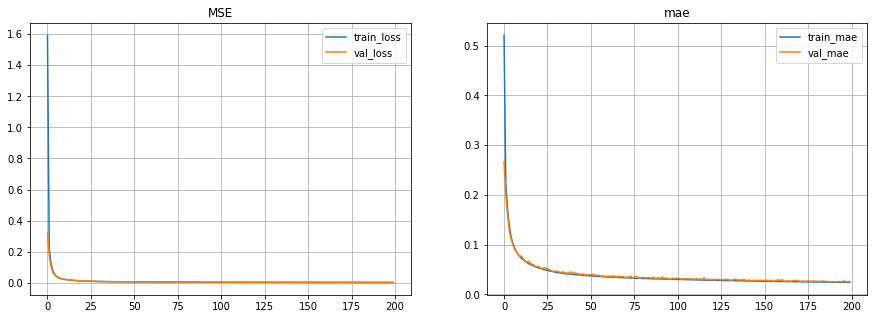

In [13]:
leap_net.visualize_convergence()

### Evaluation 

In [14]:
# TODO: log the losses
EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark1)
tf_leapnet_metrics = benchmark1.evaluate_simulator(augmented_simulator=leap_net,
                                                   eval_batch_size=128,
                                                   dataset="all",
                                                   shuffle=False,
                                                   save_path=EVAL_SAVE_PATH,
                                                   save_predictions=True
                                                  )

#### Machine Learning

<span style="color: green">**It can be observed that the LeapNet model have a much better generalization capacity than the fully connected architecture.**</span>

In [16]:
tf_leapnet_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 29.085651397705078, 'a_ex': 38.26094436645508},
 'MAE_avg': {'a_or': 3.1388704776763916, 'a_ex': 3.5962882041931152},
 'mape_avg': {'a_or': 0.020129426659524365, 'a_ex': 0.01763156745741016},
 'mape_90_avg': {'a_or': 0.008468155919543854, 'a_ex': 0.00707471637739022},
 'TIME_INF': 0.1429758999729529}

In [17]:
tf_leapnet_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 7098.3916015625, 'a_ex': 11479.880859375},
 'MAE_avg': {'a_or': 34.719993591308594, 'a_ex': 45.26488494873047},
 'mape_avg': {'a_or': 0.17385205858280545, 'a_ex': 0.1536015447523115},
 'mape_90_avg': {'a_or': 0.1467663677127829, 'a_ex': 0.15487983367700717},
 'TIME_INF': 0.17330339999170974}

#### Physics

<span style="color: green">**The rate of physics law violation by the LeapNet model is also much lower than the Fully connected model.**</span>

In [18]:
tf_leapnet_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]

0.00094

In [19]:
tf_leapnet_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]

0.004135

#### Industrial Readiness

<span style="color: purple">**However, this improvement comes with some costs.**</span>

It can be observed that the inference time for LeapNet model ($0.20$ seconds) is higher than a simpler architecture as Fully Connected approach ($0.10$ seconds) using a Nvidia Tesla M40 24GB. However, these results should be considered with some cautions, as the number of trainable parameters is not also the same for these two models.

In [20]:
tf_leapnet_metrics["test"]["IndRed"]

{'TIME_INF': 0.15973710000980645}

### Save

In [44]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark1)
leap_net.save(SAVE_PATH)

### Restore 

In [46]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler

leap_net_loaded = LeapNet(name="tf_leapnet",
                          bench_config_path=BENCH_CONFIG_PATH,
                          bench_config_name="Benchmark1",
                          sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                          sim_config_name="DEFAULT",
                          scaler=PowerGridScaler,
                          log_path=LOG_PATH)

In [47]:
LOAD_PATH = get_path(BASELINES_PATH, benchmark1)
leap_net_loaded.restore(path=LOAD_PATH)

# Benchmark2:  Remedial action search <a id="benchmark2"></a>

Once risky contingencies are identified, we need to explore possible solutions (aka "remedial actions") to recommend suitable solutions to the grid operator. In this benchmark, a solution consists in predefined topological change on the grid. It is successful if the simulation run on this modified grid alleviates the previous overflow without generating any new problem. In this case, the computation space in practice is significantly smaller compared to benchmark 1 (only small subsets of remedial actions to test over in most cases, compared to every contingency simulations). We here target  10-100 simulation batches whatever the grid size. This only depends on the number of preselected action candidates by the operator for a given risk. This benchmark includes the prediction of a few more physical variables: active power flows $p^\ell$ (in MW), current $a^\ell$ (in A) voltages $v_{k}$ (in V) at both sides of each powerline. Although this is not sufficient to fully describe the grid from a physical point of view, it is enough to give the operator some confident insights about the underlying physical behavior. For instance, is an overload somehow rather local and related to neighboring voltage drop phenomena or possibly long-distance considering power flow transmission from large power plants?


In [4]:
benchmark2 = PowerGridBenchmark(benchmark_name="Benchmark2",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

## Fully Connected Network

In [11]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

In [12]:
tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark2",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

### Load it from a save point 

In [13]:
LOAD_PATH = get_path(BASELINES_PATH, benchmark2)
tf_fc.restore(path=LOAD_PATH)

### Train the model

In [ ]:
tf_fc.train(train_dataset=benchmark2.train_dataset,
            val_dataset=benchmark2.val_dataset,
            epochs=100
           )

#### Convergence

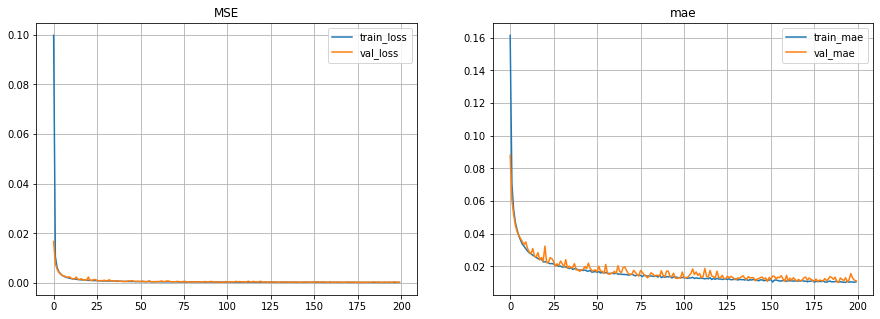

In [14]:
tf_fc.visualize_convergence()

### Evaluation 

In [ ]:
# TODO: log the losses
EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark2)
tf_fc_metrics = benchmark2.evaluate_simulator(augmented_simulator=tf_fc,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_path=None,
                                              save_predictions=False
                                             )

#### Machine Learning

In [16]:
print("MAPE90 for a_or: ", tf_fc_metrics["test"]["ML"]["mape_90_avg"]["a_or"])
print("MAPE90 for a_ex: ", tf_fc_metrics["test"]["ML"]["mape_90_avg"]["a_ex"])
print("MAPE for p_or: ", tf_fc_metrics["test"]["ML"]["mape_avg"]["p_or"])
print("MAPE for p_ex: ", tf_fc_metrics["test"]["ML"]["mape_avg"]["p_ex"])
print("MAE for p_or: ", tf_fc_metrics["test"]["ML"]["MAE_avg"]["p_or"])
print("MAE for p_ex: ", tf_fc_metrics["test"]["ML"]["MAE_avg"]["p_ex"])
print("MAPE for v_or: ", tf_fc_metrics["test"]["ML"]["mape_avg"]["v_or"])
print("MAPE for v_ex: ", tf_fc_metrics["test"]["ML"]["mape_avg"]["v_ex"])
print("MAE for v_or: ", tf_fc_metrics["test"]["ML"]["MAE_avg"]["v_or"])
print("MAE for v_ex: ", tf_fc_metrics["test"]["ML"]["MAE_avg"]["v_ex"])

MAPE90 for a_or:  0.005536789221894804
MAPE90 for a_ex:  0.005456813765815972
MAPE for p_or:  0.00862245821668557
MAPE for p_ex:  0.008477684866954915
MAE for p_or:  0.09964931011199951
MAE for p_ex:  0.09761589020490646
MAPE for v_or:  0.0008934855225970473
MAPE for v_ex:  0.000903380139934273
MAE for v_or:  0.08649303764104843
MAE for v_ex:  0.06617464125156403


In [17]:
print("MAPE90 for a_or: ", tf_fc_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_or"])
print("MAPE90 for a_ex: ", tf_fc_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_ex"])
print("MAPE for p_or: ", tf_fc_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_or"])
print("MAPE for p_ex: ", tf_fc_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_ex"])
print("MAE for p_or: ", tf_fc_metrics["test_ood_topo"]["ML"]["MAE_avg"]["p_or"])
print("MAE for p_ex: ", tf_fc_metrics["test_ood_topo"]["ML"]["MAE_avg"]["p_ex"])
print("MAPE for v_or: ", tf_fc_metrics["test_ood_topo"]["ML"]["mape_avg"]["v_or"])
print("MAPE for v_ex: ", tf_fc_metrics["test_ood_topo"]["ML"]["mape_avg"]["v_ex"])
print("MAE for v_or: ", tf_fc_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_or"])
print("MAE for v_ex: ", tf_fc_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_ex"])

MAPE90 for a_or:  0.10189347920204068
MAPE90 for a_ex:  0.10297622870481608
MAPE for p_or:  0.14747703100434326
MAPE for p_ex:  0.1472255111784983
MAE for p_or:  1.7987455129623413
MAE for p_ex:  1.7728214263916016
MAPE for v_or:  0.004895506836363069
MAPE for v_ex:  0.004960453678566542
MAE for v_or:  0.4244811534881592
MAE for v_ex:  0.34588274359703064


#### Physics

In [18]:
print("1) Current positivity violation:", (tf_fc_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+tf_fc_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
if tf_fc_metrics["test"]["Physics"]["VOLTAGE_POS"]:
    print("2) Voltage positivity violation:", (tf_fc_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+tf_fc_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
else:
    print("2) Voltage positivity violation:", 0)
print("3) Loss positivity violation:", tf_fc_metrics["test"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", tf_fc_metrics["test"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", tf_fc_metrics["test"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(tf_fc_metrics["test"]["Physics"]["CHECK_GC"]["violation_percentage"], tf_fc_metrics["test"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(tf_fc_metrics["test"]["Physics"]["CHECK_LC"]["violation_percentage"], tf_fc_metrics["test"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", tf_fc_metrics["test"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

1) Current positivity violation: 0.0114725
2) Voltage positivity violation: 0.013675
3) Loss positivity violation: 0.16484
4) Disconnected lines violation: {}
5) Violation of loss to be between [1,4]% of production: 0.18
6) Violation of global conservation: 99.4% and its weighted mape: 0.027306463569402695
7) Violation of local conservation: 89.68142857142857% and its weighted mape: 0.005147017177159799
8) Violation proportion of voltage equality at subs: 0.9976333333333334


In [19]:
print("1) Current positivity violation:", (tf_fc_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+tf_fc_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
if tf_fc_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]:
    print("2) Voltage positivity violation:", (tf_fc_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+tf_fc_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
else:
    print("2) Voltage positivity violation:", 0)
print("3) Loss positivity violation:", tf_fc_metrics["test_ood_topo"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", tf_fc_metrics["test_ood_topo"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", tf_fc_metrics["test_ood_topo"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(tf_fc_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["violation_percentage"], tf_fc_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(tf_fc_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["violation_percentage"], tf_fc_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", tf_fc_metrics["test_ood_topo"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

1) Current positivity violation: 0.011865
2) Voltage positivity violation: 0.013049999999999999
3) Loss positivity violation: 0.20383
4) Disconnected lines violation: {}
5) Violation of loss to be between [1,4]% of production: 0.36
6) Violation of global conservation: 99.81% and its weighted mape: 0.1251574009656906
7) Violation of local conservation: 97.77785714285714% and its weighted mape: 0.023546348198665402
8) Violation proportion of voltage equality at subs: 0.99536875


#### Industrial Readiness

In [20]:
print(f'Inference time for test dataset: {tf_fc_metrics["test"]["IndRed"]["TIME_INF"]:.2f}s')
print(f'Inference time for OOD dataset: {tf_fc_metrics["test_ood_topo"]["IndRed"]["TIME_INF"]:.2f}s')

Inference time for test dataset: 0.28s
Inference time for OOD dataset: 0.30s


### Save

In [74]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark2)
tf_fc.save(SAVE_PATH)

## LeapNet Neural Network

In [5]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler

In [6]:
leap_net = LeapNet(name="tf_leapnet",
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark2",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT",
                   sizes_main=(150, 150),
                   sizes_enc=(20, 20, 20),
                   sizes_out=(100, 40),
                   scaler=PowerGridScaler,
                   log_path=LOG_PATH)

### Load it

In [ ]:
LOAD_PATH = get_path(BASELINES_PATH, benchmark2)
leap_net.restore(path=LOAD_PATH)

### or Train it

In [ ]:
leap_net.train(train_dataset=benchmark2.train_dataset,
               val_dataset=benchmark2.val_dataset,
               epochs=200
              )

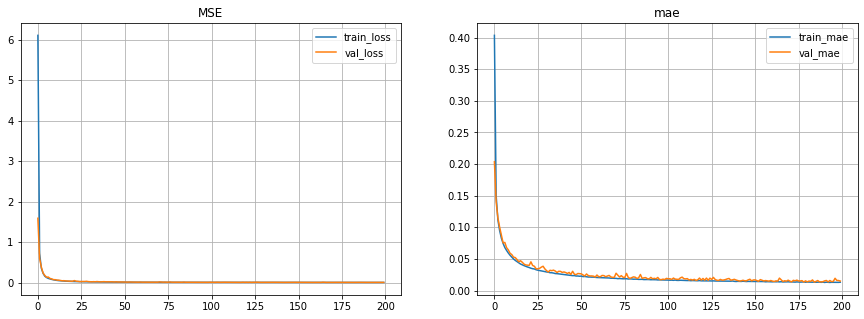

In [18]:
leap_net.visualize_convergence()

### Evaluation 

In [ ]:
# TODO: log the losses
EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark2)
tf_leapnet_metrics = benchmark2.evaluate_simulator(augmented_simulator=leap_net,
                                                   eval_batch_size=128,
                                                   dataset="all",
                                                   shuffle=False,
                                                   save_path=EVAL_SAVE_PATH,
                                                   save_predictions=True
                                                  )

#### Machine Learning

In [20]:
print("MAPE90 for a_or: ", tf_leapnet_metrics["test"]["ML"]["mape_90_avg"]["a_or"])
print("MAPE90 for a_ex: ", tf_leapnet_metrics["test"]["ML"]["mape_90_avg"]["a_ex"])
print("MAPE for p_or: ", tf_leapnet_metrics["test"]["ML"]["mape_avg"]["p_or"])
print("MAPE for p_ex: ", tf_leapnet_metrics["test"]["ML"]["mape_avg"]["p_ex"])
print("MAE for p_or: ", tf_leapnet_metrics["test"]["ML"]["MAE_avg"]["p_or"])
print("MAE for p_ex: ", tf_leapnet_metrics["test"]["ML"]["MAE_avg"]["p_ex"])
print("MAPE for v_or: ", tf_leapnet_metrics["test"]["ML"]["mape_avg"]["v_or"])
print("MAPE for v_ex: ", tf_leapnet_metrics["test"]["ML"]["mape_avg"]["v_ex"])
print("MAE for v_or: ", tf_leapnet_metrics["test"]["ML"]["MAE_avg"]["v_or"])
print("MAE for v_ex: ", tf_leapnet_metrics["test"]["ML"]["MAE_avg"]["v_ex"])

MAPE90 for a_or:  0.009169327684259786
MAPE90 for a_ex:  0.008609933790241586
MAPE for p_or:  0.014057445321708958
MAPE for p_ex:  0.013013509064890818
MAE for p_or:  0.1869640052318573
MAE for p_ex:  0.1794859915971756
MAPE for v_or:  0.0016585458785211362
MAPE for v_ex:  0.002299098771987526
MAE for v_or:  0.1258997619152069
MAE for v_ex:  0.1404215395450592


In [21]:
print("MAPE90 for a_or: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_or"])
print("MAPE90 for a_ex: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_ex"])
print("MAPE for p_or: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_or"])
print("MAPE for p_ex: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_ex"])
print("MAE for p_or: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["MAE_avg"]["p_or"])
print("MAE for p_ex: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["MAE_avg"]["p_ex"])
print("MAPE for v_or: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["mape_avg"]["v_or"])
print("MAPE for v_ex: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["mape_avg"]["v_ex"])
print("MAE for v_or: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_or"])
print("MAE for v_ex: ", tf_leapnet_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_ex"])

MAPE90 for a_or:  0.12464728719732017
MAPE90 for a_ex:  0.11647447512493583
MAPE for p_or:  0.22522913805762063
MAPE for p_ex:  0.23975308257265215
MAE for p_or:  2.7297797203063965
MAE for p_ex:  2.783205509185791
MAPE for v_or:  0.003705198642726069
MAPE for v_ex:  0.004044990850530969
MAE for v_or:  0.257049560546875
MAE for v_ex:  0.24137432873249054


#### Physics

In [26]:
print("1) Current positivity violation:", (tf_leapnet_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+tf_leapnet_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
if tf_leapnet_metrics["test"]["Physics"]["VOLTAGE_POS"]:
    print("2) Voltage positivity violation:", (tf_leapnet_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+tf_leapnet_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
else:
    print("2) Voltage positivity violation:", 0)
print("3) Loss positivity violation:", tf_leapnet_metrics["test"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", tf_leapnet_metrics["test"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", tf_leapnet_metrics["test"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(tf_leapnet_metrics["test"]["Physics"]["CHECK_GC"]["violation_percentage"], tf_leapnet_metrics["test"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(tf_leapnet_metrics["test"]["Physics"]["CHECK_LC"]["violation_percentage"], tf_leapnet_metrics["test"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", tf_leapnet_metrics["test"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

1) Current positivity violation: 0.00027749999999999997
2) Voltage positivity violation: 0
3) Loss positivity violation: 0.308235
4) Disconnected lines violation: {}
5) Violation of loss to be between [1,4]% of production: 0.62
6) Violation of global conservation: 99.95% and its weighted mape: 0.2836044132709503
7) Violation of local conservation: 96.09071428571428% and its weighted mape: 0.01215424724119231
8) Violation proportion of voltage equality at subs: 0.9977266666666667


In [27]:
print("1) Current positivity violation:", (tf_leapnet_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+tf_leapnet_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
if tf_leapnet_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]:
    print("2) Voltage positivity violation:", (tf_leapnet_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+tf_leapnet_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
else:
    print("2) Voltage positivity violation:", 0)
print("3) Loss positivity violation:", tf_leapnet_metrics["test_ood_topo"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", tf_leapnet_metrics["test_ood_topo"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", tf_leapnet_metrics["test_ood_topo"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(tf_leapnet_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["violation_percentage"], tf_leapnet_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(tf_leapnet_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["violation_percentage"], tf_leapnet_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", tf_leapnet_metrics["test_ood_topo"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

1) Current positivity violation: 0.0031349999999999998
2) Voltage positivity violation: 0
3) Loss positivity violation: 0.480745
4) Disconnected lines violation: {}
5) Violation of loss to be between [1,4]% of production: 40.88
6) Violation of global conservation: 100.0% and its weighted mape: 2.222123861312866
7) Violation of local conservation: 98.59285714285714% and its weighted mape: 0.10475341232364434
8) Violation proportion of voltage equality at subs: 0.9957


#### Industrial Readiness

In [30]:
print(f'Inference time for test dataset: {tf_leapnet_metrics["test"]["IndRed"]["TIME_INF"]:.2f}s')
print(f'Inference time for OOD dataset: {tf_leapnet_metrics["test_ood_topo"]["IndRed"]["TIME_INF"]:.2f}s')

Inference time for test dataset: 0.20s
Inference time for OOD dataset: 0.22s


### Save

In [31]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark2)
leap_net.save(SAVE_PATH)

# Benchmark 3 : Validation of decision <a id="benchmark3"></a>
Once preferred solutions have been selected by the operator to alleviate an overflow, a last detailed simulation is run and studied more in depth by the operator, prior to apply the remedial actions on the actual power grid. The purpose of this operation is to ensure that no unforeseen event may make the grid collapse. In this application, the quality of prediction is decisive, to ensure that the adopted interventions will not violate the consistency within the network; therefore the surrogate simulator shall be nearly as good as the numerical solver. Here the main goal is to ensure the accuracy and consistency of the solution for 1-10 simulations. All physical variables of the physical problem shall be predicted: currents $a^\ell$, active power flows $p^\ell$, voltages $v_{k}$, reactive power flows $q^\ell$, angles $\theta_k$.

In [ ]:
benchmark3 = PowerGridBenchmark(benchmark_name="Benchmark3",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

In [ ]:
benchmark3.config.get_options_dict()

## Fully Connected Network

In [ ]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.dataset.scaler import StandardScaler

In [ ]:
tf_fc = TfFullyConnected(name="tf_fc",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark3",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         scaler=StandardScaler,
                         log_path=LOG_PATH)

### Train the model

In [ ]:
tf_fc.train(train_dataset=benchmark3.train_dataset,
            val_dataset=benchmark3.val_dataset,
            epochs=100
           )

#### Convergence

In [ ]:
tf_fc.visualize_convergence()

### Evaluation 

In [ ]:
# TODO: log the losses
EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark3)
tf_fc_metrics = benchmark3.evaluate_simulator(augmented_simulator=tf_fc,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_path=EVAL_SAVE_PATH,
                                              save_predictions=True
                                             )

### Save

In [ ]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark3)
tf_fc.save(SAVE_PATH)

## LeapNet Neural Network

In [ ]:
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler import PowerGridScaler

In [ ]:
leap_net = LeapNet(name="tf_leapnet",
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark3",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT",
                   sizes_main=(150, 150),
                   sizes_enc=(20, 20, 20),
                   sizes_out=(100, 40),
                   scaler=PowerGridScaler,
                   log_path=LOG_PATH)

### Train it

In [ ]:
leap_net.train(train_dataset=benchmark3.train_dataset,
               val_dataset=benchmark3.val_dataset,
               epochs=200
              )

In [ ]:
leap_net.visualize_convergence()

### Evaluation 

In [ ]:
# TODO: log the losses
EVAL_SAVE_PATH = get_path(EVALUATION_PATH, benchmark3)
tf_leapnet_metrics = benchmark3.evaluate_simulator(augmented_simulator=leap_net,
                                                   eval_batch_size=128,
                                                   dataset="all",
                                                   shuffle=False,
                                                   save_path=EVAL_SAVE_PATH,
                                                   save_predictions=True
                                                  )

### Save

In [ ]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark3)
leap_net.save(SAVE_PATH)